In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import time


Рассмотрим задачу минимизации кусочно-линейной функции на сфере
\begin{equation}
\begin{split}
&\min_{x\in R^n} \left \{ f(x) = \max_{1 \leq i \leq k} (a_i^Tx -b_i) \right \}\\
&\text{subject to}\\
&\|x-x_0\|_2^2 \leq \sigma^2
\end{split}
\end{equation}



1. Построим сглаженную версию целевой функции $f_{\mu}(x)$ с параметром гладкости $\mu$


2. Реализуем быстрый градиентный метод из статьи (Nesterov, 2005)


---



Указанная выше задача может быть записана в эквивалентном виде

\begin{equation}
\begin{split}
&\min_{x\in R^n, t} t \\
&\text{subject to}\\
&a_i^Tx -b_i \leq t, \quad 1\leq i\leq k\\
&\|x-x_0\|_2^2 \leq \sigma^2
\end{split}
\end{equation}

Реализуем её с помощью барьерного метода и сравним результаты с быстрым градиентным

# Part 1

# Function smoothing

$$\min_{x\in R^n} \left \{ f(x) = \max_{1 \leq i \leq k} (a_i^Tx -b_i) \right \}$$
Функции $(a_i^Tx -b_i)$ - выпуклые, тогда мы можем нашу функцию представить на единичном k-мерном симплексе:
$$Q = \{u \in \mathbf{R}^k| \sum\limits_{i = 1}^{k} u_i = 1, u_i\geqslant 0 \ \forall i = \overline{1,k}\}$$
Тогда наша функция имеет вид:
$$f(x) = \max\limits_{u \in Q} \sum\limits_{i = 1}^{k} u_i(a_i^Tx -b_i)$$
Рассмотрим технику сглаживания:
$$f(x) \rightarrow \min\limits_{x \in Q_1}$$
$$f(x) = \max\limits_{u \in Q_2} (u^TAx -\varphi_2(u)) + \varphi_1(x)$$
Где $\varphi_2(u)$ и $\varphi_1(x)$ - гладкие и выпуклые функции, а $\max\limits_{u \in Q_2} (u^TAx -\varphi_2(u))$ - явно не гладкая. В нашем случае $\varphi_1(x) = 0$. Остаётся только негладкая часть.

Рассмотрим такую функцию $d(u)$ - ($\theta$ - сильно выпуклую) и равную нулю в своей оптимальной точке. Тогда нашу функцию $f(x)$ мы будем приближать гладкой функцией $f_{\mu}(x) = \max\limits_{u \in Q_2} (u^TAx -\varphi_2(u) - \mu d(u)) + \varphi_1(x)$. Значит теперь мы работаем с функцией $f_{\mu}(x)$:
$$f_{\mu}(x) \rightarrow \min\limits_{x \in Q_1}$$
$$f_{\mu}(x) \leqslant f(x) \leqslant f_{\mu}(x) + \mu \max\limits_{u \in Q_2} d(u)$$
Обычно для сглаживания на единичном симплексе выбирают функцию энтропии: $\widetilde{d(u)} = \sum\limits_{i = 1}^{k} u_{i}ln(u_{i})$. Найдём её минимум на $Q$:

Метод множителей Лагранжа: 
$$\widetilde{L(u,\lambda)} = \sum\limits_{i = 1}^{k} u_{i}ln(u_{i}) + \lambda(\sum\limits_{i = 1}^{k} u_{i} - 1)$$
$$\nabla_{u_i}\widetilde{L(u,\lambda)} = ln(u^*_i) + 1 + \lambda = 0 \Rightarrow u^*_i = e^{-(1 + \lambda)} \ \forall i = \overline{1,k}$$
$$\sum\limits_{i = 1}^{k} e^{-(1 + \lambda)} = 1 \Rightarrow e^{-(1 + \lambda)} = \frac{1}{k} \Rightarrow \lambda = ln(k) - 1 \Rightarrow u^*_i = \frac{1}{k} \gt 0  \  \forall i = \overline{1,k}$$
Значение функции в точке минимума: $\widetilde{d(u^*)} = -ln(k)$. Значит наша функция $d(u) = \sum\limits_{i = 1}^{k} u_{i}ln(u_{i}) + ln(k)$, т.к $d(u^*) = 0$ и $u^* \in Q$ 
Тогда наша функция $f_\mu$ имеет вид:
$$f_\mu = \max\limits_{u \in Q} [\sum\limits_{i = 1}^{k} u_i(a_i^Tx -b_i) - \mu(\sum\limits_{i = 1}^{k} u_{i}ln(u_{i}) + ln(k))]$$
Рассмотрим функцию $-f_\mu$ и запишем для неё Лагранжиан:
$$L(u, \lambda, \nu) = -\sum\limits_{i = 1}^{k} u_i(a_i^Tx -b_i) + \mu \sum\limits_{i = 1}^{k} u_{i}ln(u_{i}) + \mu ln(k) -\sum\limits_{i = 1}^{k} \nu_i u_i + \lambda(\sum\limits_{i = 1}^{k} u_i - 1)$$
Тогда запишем ККТ:
$$
\begin{cases}
\nabla_{u_i} L(u, \lambda^*, \nu^*) = 0 & (1)\\
\sum\limits_{i = 1}^{k} u^*_i = 1, u^*_i\geqslant 0 \ \forall i = \overline{1,k} & (2) \\
\nu^*_i u^*_i = 0 & (3)\\
\nu^*_i \geqslant 0 & (4)
\end{cases}
$$
$$\nabla_{u_i} L(u, \lambda^*, \nu^*) = -(a_i^Tx -b_i) + \mu(1 + ln(u^*_i)) - \nu^*_i + \lambda^* = 0 \Rightarrow u^*_{i} = exp(\frac{a_i^Tx -b_i + \nu^*_i - \lambda^* - \mu}{\mu}) \ \forall i = \overline{1,k}$$
Заметим, что $u^*_{i} \gt 0 \ \forall i = \overline{1,k}$, тогда из (3) следует, что $\nu^*_i = 0\ \forall i = \overline{1,k}$. Тогда $u^*_{i}$ имеет вид:
$$u^*_{i} = exp(\frac{a_i^Tx -b_i - \lambda^* - \mu}{\mu}) \ \forall i = \overline{1,k}$$
Тогда из (2) следует:
$$\sum\limits_{i = 1}^{k} exp(\frac{a_i^Tx -b_i}{\mu}) exp(\frac{- \lambda^* - \mu}{\mu}) = 1 \Rightarrow exp(\frac{- \lambda^* - \mu}{\mu}) = \frac{1}{\sum\limits_{i = 1}^{k} exp(\frac{a_i^Tx -b_i}{\mu})}$$
$$u^*_{i} = \frac{exp(\frac{a_i^Tx -b_i}{\mu})}{\sum\limits_{i = 1}^{k} exp(\frac{a_i^Tx -b_i}{\mu})} \ \forall i = \overline{1,k}$$
Так как минимум функции $-f_\mu$ совпадает с максимумом $f_\mu$, тогда функция $f_\mu$ имеет вид:
$$f_\mu = \sum\limits_{i = 1}^{k}(\frac{exp(\frac{a_i^Tx -b_i}{\mu})}{\sum\limits_{j = 1}^{k} exp(\frac{a_j^Tx -b_j}{\mu})})(a_i^Tx -b_i) - \mu\sum\limits_{i = 1}^{k}(\frac{exp(\frac{a_i^Tx -b_i}{\mu})}{\sum\limits_{j = 1}^{k} exp(\frac{a_j^Tx -b_j}{\mu})})((a_i^Tx -b_i) - ln(\sum\limits_{j = 1}^{k} exp(\frac{a_j^Tx -b_j}{\mu}))) - \mu ln(k)$$
$$f_\mu = \mu\sum\limits_{i = 1}^{k}(\frac{exp(\frac{a_i^Tx -b_i}{\mu})}{\sum\limits_{j = 1}^{k} exp(\frac{a_j^Tx -b_j}{\mu})}) ln(\sum\limits_{j = 1}^{k} exp(\frac{a_j^Tx -b_j}{\mu}))) - \mu ln(k)$$
Итог:
$$f_\mu = \mu ln(\sum\limits_{j = 1}^{k} exp(\frac{a_j^Tx -b_j}{\mu}))) - \mu ln(k)$$

# Fast Gradient Descent

Будем решать задачу:
$$
\begin{equation}
\begin{split}
&\mu ln(\sum\limits_{j = 1}^{k} exp(\frac{a_j^Tx -b_j}{\mu}))) - \mu ln(k) \rightarrow \min\limits_{x \in \mathbf{R}^n} \\
&\text{subject to}\\
&\|x-x_0\|_2^2 \leq \sigma^2
\end{split}
\end{equation}$$
Посчитаем $\nabla f_\mu$:
$$\nabla f_\mu = \sum\limits_{i = 1}^k \frac{a_{i}exp(\frac{a_i^Tx -b_i}{\mu})}{\sum\limits_{j = 1}^{k} exp(\frac{a_j^Tx -b_j)}{\mu})}$$
Функция $f_\mu$ - с Липшицевым градиентом $\Rightarrow$ $f_\mu(y) - f_\mu(x) \leqslant <\nabla f_\mu(x), y-x> + \frac{L\|y-x\|^2_2}{2}$. Пусть множество $T_Q(x) \subset Q$ - множество оптимальных решений того, что справа, где $Q = \{x \in \mathbf{R}^n | \|x-x_0\|^2_2 \leqslant \sigma^2\}$ 
$$T_Q(x) = arg\min\limits_{y \in Q} \{<\nabla f_\mu(x), y-x> + \frac{L\|y-x\|^2_2}{2}\}$$
$$T_Q(x) = arg\min\limits_{y \in Q} \{<\nabla f_\mu(x), y> + \frac{L\|y\|^2_2}{2} - L<x,y>\}$$
$$T_Q(x) = arg\min\limits_{y \in Q} \{<\nabla f_\mu(x) -Lx, y> + \frac{L\|y\|^2_2}{2} - L<x_0,y> + L<x_0,y>\}$$
$$T_Q(x) = arg\min\limits_{y \in Q} \{<\nabla f_\mu(x) -Lx +Lx_0, y - x_0> + \frac{L\|y - x_0\|^2_2}{2}\}$$
$$T_Q(x) = x_ 0 + arg\min\limits_{z \in \widetilde{Q}} \{<\nabla f_\mu(x) -Lx +Lx_0, z> + \frac{L\|z\|^2_2}{2}\}, \widetilde{Q} = \{x \in \mathbf{R}^n | \|x\|_2^2 \leqslant \sigma^2\}$$
ККТ:
$$L(z, \lambda) = <\nabla f_\mu(x) -Lx +Lx_0, z> + \frac{L\|z\|^2_2}{2}\ + \lambda (\|z\|_2^2 - \sigma^2)$$
$$\nabla_z L(z, \lambda) = \nabla f_\mu(x) -Lx +Lx_0 + Lz + 2\lambda z = 0 \Rightarrow \lambda = \frac{-\nabla f_\mu(x) +Lx -Lx_0 - Lz}{2z}$$
$$\lambda (\|z\|_2^2 - \sigma^2) = 0 \Rightarrow z = x - x_0 -\frac{\nabla f_\mu(x)}{L} \ or \  \|z\|_2^2 = \sigma^2$$
Чтобы получить минимальное значение, при выходе за множество мы берём вектор z, длины $\sigma$, который имеет направление, противоположное $\nabla f_\mu(x) -Lx +Lx_0$. Итого:
$$ T_Q(x) =
\begin{cases}
x - \frac{\nabla f_\mu(x)}{L}, & \|x - x_0 -\frac{\nabla f_\mu(x)}{L}\|_2^2 \leqslant \sigma^2\\ 
x_0 + (x - x_0 - \frac{\nabla f_\mu(x)}{L}) \times \frac{\sigma}{\|x - x_0 -\frac{\nabla f_\mu(x)}{L}\|_2}, & \|x - x_0 -\frac{\nabla f_\mu(x)}{L}\|_2^2 \gt \sigma^2 
\end{cases}
$$
Теперь найдём $z_k$:
$$z_k = arg \min\limits_x \{\frac{L}{\xi} d(x) + \sum\limits_{i = 0}^k \frac{i+1}{2}[f_\mu(x_i) + <\nabla f_\mu(x_i), x - x_i>], x \in Q\}$$
Берём сильно выпуклую функцию $d(x) = \frac{1}{2}\|x -x_0\|_2^2$ на $Q$ с параметром сильной выпуклости $\xi$. Тогда:
$$z_k = arg \min\limits_x \{\frac{L}{2\xi} \|x - x_0\|_2^2 + \sum\limits_{i = 0}^k \frac{i+1}{2}[f_\mu(x_i) + <\nabla f_\mu(x_i), x - x_i>], x \in Q\}$$
$$z_k = arg \min\limits_x \{\frac{L}{2\xi} \|x-x_0\|_2^2 + \sum\limits_{i = 0}^k \frac{i+1}{2}[<\nabla f_\mu(x_i), x>], x \in Q\}$$
$$z_k = arg \min\limits_x \{\frac{L}{2\xi} \|x - x_0\|_2^2 + <\sum\limits_{i = 0}^k \frac{i+1}{2} \nabla f_\mu(x_i), x - x_0>, x \in Q\}$$
$$z_k = x_ 0 + arg \min\limits_{z \in \widetilde{Q}} \{\frac{L}{2\xi} \|z\|_2^2 + <\sum\limits_{i = 0}^k \frac{i+1}{2} \nabla f_\mu(x_i), z>\}$$
Аналогично $T_Q(x)$ находим $z_k$:
$$\begin{cases}
x_0 - \frac{\xi}{L} (\sum\limits_{i = 0}^k \frac{i+1}{2} \nabla f_\mu(x_i)), & \| \frac{\xi}{L} (\sum\limits_{i = 0}^k \frac{i+1}{2} \nabla f_\mu(x_i))\|_2^2 \leqslant \sigma^2\\ 
x_0 - (\frac{\xi}{L} (\sum\limits_{i = 0}^k \frac{i+1}{2} \nabla f_\mu(x_i)) \times \frac{\sigma}{\|\frac{\xi}{L} (\sum\limits_{i = 0}^k \frac{i+1}{2} \nabla f_\mu(x_i))\|_2}, & \| \frac{\xi}{L} (\sum\limits_{i = 0}^k \frac{i+1}{2} \nabla f_\mu(x_i))\|_2^2 \gt \sigma^2
\end{cases}
$$
Итого метод выглядит следующим образом:
$$
\begin{equation}
\begin{split}
& Compute \ \ f_\mu = \mu ln(\sum\limits_{j = 1}^{k} exp(\frac{a_j^Tx -b_j}{\mu}))) - \mu ln(k), \nabla f_{\mu} =  \sum\limits_{i = 1}^k \frac{a_{i}exp(\frac{a_i^Tx -b_i}{\mu})}{\sum\limits_{j = 1}^{k} exp(\frac{a_j^Tx -b_j)}{\mu})}\\
& Compute \ \  y_k = T_Q(x_k) = \begin{cases}
x - \frac{\nabla f_\mu(x)}{L}, & \|x - x_0 -\frac{\nabla f_\mu(x)}{L}\|_2^2 \leqslant \sigma^2\\ 
x_0 + (x - x_0 - \frac{\nabla f_\mu(x)}{L}) \times \frac{\sigma}{\|x - x_0 -\frac{\nabla f_\mu(x)}{L}\|_2}, & \|x - x_0 -\frac{\nabla f_\mu(x)}{L}\|_2^2 \gt \sigma^2 
\end{cases}\\
& Compute \ \ z_k = \begin{cases}
x_0 - \frac{\xi}{L} (\sum\limits_{i = 0}^k \frac{i+1}{2} \nabla f_\mu(x_i)), & \| \frac{\xi}{L} (\sum\limits_{i = 0}^k \frac{i+1}{2} \nabla f_\mu(x_i))\|_2^2 \leqslant \sigma^2\\ 
x_0 - (\frac{\xi}{L} (\sum\limits_{i = 0}^k \frac{i+1}{2} \nabla f_\mu(x_i)) \times \frac{\sigma}{\|\frac{\xi}{L} (\sum\limits_{i = 0}^k \frac{i+1}{2} \nabla f_\mu(x_i))\|_2}, & \| \frac{\xi}{L} (\sum\limits_{i = 0}^k \frac{i+1}{2} \nabla f_\mu(x_i))\|_2^2 \gt \sigma^2
\end{cases} \\
& Make \ \ x_{k+1} = \frac{2}{k+3}z_k + \frac{k+1}{k+3} y_k
\end{split}
\end{equation}
$$

# CODE

In [ ]:
def function_mu(k, A, b, x):
    result = - mu*np.log(k)
    for i in range(k):
        result += mu * np.log(np.exp(np.array((np.matrix(A[i, :]) @ x.T - b[0][i])/mu)))
    return np.array(result)[0][0]

In [ ]:
def gradient_mu(k, A, b, x):
    value_temp = 0
    result = 0
    for i in range(k):
        value_temp += np.exp(np.array((np.matrix(A[i, :]) @ x.T - b[0][i])/mu))
    value = np.array(value_temp)[0][0]
    for j in range(k):
        result += np.exp(np.array((np.matrix(A[j, :]) @ x.T - b[0][j])/mu))/value * A[j,:]
    return result

In [ ]:
def y_new(k, A, b, x):
    check_value = np.linalg.norm((x - x_0 - gradient_mu(k, A, b, x)/L), ord=2)
    if check_value**2 <= sigma**2:
        return x - gradient_mu(k, A, b, x)/L
    else: 
        return x_0 + (x - x_0 - gradient_mu(k, A, b, x)/L) *sigma/check_value

In [ ]:
def Fast_Gradient_Descent(x, k, A, b, max_iter = 1000, ksi = 1.0):
    check_vector = ksi/(2*L) * (gradient_mu(k, A, b, x))
    check_value = np.linalg.norm(check_vector, ord=2) 
    if check_value**2 <= sigma**2:
        z = x_0 - check_vector
    else: 
        z = x_0 - sigma/check_value * check_vector
    y = y_new(k, A, b, x)
    data = []
    time_data = []
    start_time = time.time()
    for i in tqdm(range(1, max_iter)):
        x = 2/(i+3) * z + (i+1)/(i+3) * y
        y = y_new(k, A, b, x)
        check_vector += ksi/(L) * (i+1)/2 * (gradient_mu(k, A, b, x))
        check_value = np.linalg.norm(check_vector, ord=2) 
        if check_value**2 <= sigma**2:
            z = x_0 - check_vector
        else: 
            z = x_0 - sigma/check_value * check_vector
        data.append(np.max(A @ x.T - b))
        time_data.append(time.time() - start_time)
    return data, time_data

# Part 2

$$
\begin{equation}
\begin{split}
&\min_{x\in R^n, t} t \\
&\text{subject to}\\
&a_i^Tx -b_i \leq t, \quad 1\leq i\leq k\\
&\|x-x_0\|_2^2 \leq \sigma^2
\end{split}
\end{equation}
$$
Добавляем барьеры: 
$$
\begin{equation}
\begin{split}
&t + \sum\limits_{i = 1}^k \mathbb{1}_{-}(a_i^Tx - b_i - t) + \mathbb{1}_{-}(\|x-x_0\|_2^2 - \sigma^2) \rightarrow \min, \ \ \ \ \mathbb{1}_{-}(u) = 
\begin{cases}
0 \ , & u \leqslant 0 \\ 
+\infty \ ,  & else 
\end{cases}\\
\end{split}
\end{equation}
$$
$$
\mathbb{1}_{-}(u) = - \frac{1}{r_k} ln(-u), \ \ \ r_k = \theta \cdot r_{k-1}, \ \ \theta \gt 1$$
$$\varphi(x, t) = - \sum\limits_{i = 1}^k ln(t + b_i - a_i^Tx) - ln(\sigma^2 - \|x-x_0\|_2^2)$$ 
Барьерный метод: 
Given: strictly feasible x = arg $\min(\varphi(x, t))$, $r = r_0$, $\theta \gt 1$, $\epsilon \gt 0$

for $m \geqslant 1:$

Compute: $
\begin{equation*}
\left(
\begin{array}{cc}
t^*(r_m) & x^*(r_m)  \\
\end{array}
\right)
\end{equation*} = arg \min (r_m \cdot t + \varphi(x, t))$

Update: $\begin{equation*}
\left(
\begin{array}{cc}
t & x  \\
\end{array}
\right)
\end{equation*} = \left(
\begin{array}{cc}
t^*(r_m) & x^*(r_m)  \\
\end{array}
\right)$

Check: $\frac{l}{r_m} \lt \epsilon$, где l - количество ограничений

If wrong: $r_{m + 1} = r_m \cdot \theta$

С помощью метода Ньютона найдём $r_m \cdot t + \varphi(x, t) \rightarrow min$. Пусть $f(x, t) = r_m \cdot t + \varphi(x)$. Тогда метод Ньютона выглядит следующим образом:
$$r_m \cdot t + \varphi(x, t) \rightarrow min$$
$$\nabla_x f(x, t) = \sum_{i = 1}^{k} \frac{a_i}{t + b_i - a_i^Tx} + \frac{2(x - x_0)}{\sigma^2 - \|x-x_0\|_2^2}$$
$$\nabla_{xx}^2 f(x, t) = \sum_{i = 1}^{k} \frac{a_ia^T_i}{(t + b_i - a_i^Tx)^2} + \frac{2 * I}{\sigma^2 - \|x-x_0\|_2^2} + \frac{4(x-x_0)(x-x_0)^T}{(\sigma^2 - \|x-x_0\|_2^2)^2}$$
$$\nabla_t f(x, t) = r_ k - \sum_{i = 1}^{k} \frac{1}{t + b_i - a_i^Tx}$$
$$\nabla^2_{tx} f(x, t) = \nabla^2_{xt} f(x, t) = - \sum_{i = 1}^{k} \frac{a_i}{(t + b_i - a_i^Tx)^2}$$
$$\nabla^2_{tt} f(x, t) = \sum_{i = 1}^{k} \frac{1}{(t + b_i - a_i^Tx)^2}$$
Значит градиент и гессиан выглядят так:
$$ 
\begin{equation*}
\nabla f(t, x) = r_k \left(
\begin{array}{c}
1  \\
0  \\
\end{array}
\right) + \sum_{i = 1}^{k} \frac{1}{t + b_i - a_i^Tx} \left(
\begin{array}{c}
-1  \\
a_i  \\
\end{array}
\right) + \frac{2}{\sigma^2 - \|x-x_0\|_2^2} \left(
\begin{array}{c}
0  \\
x - x_0  \\
\end{array}
\right)
\end{equation*}
$$
$$
\begin{equation*}
\nabla^2 f(t,x) = \sum_{i = 1}^{k} \frac{1}{(t + b_i - a_i^Tx)^2} \left(
\begin{array}{cc}
1 & -a_i^T  \\
-a_i & a_ia^T_i  \\
\end{array}
\right) + \frac{2}{\sigma^2 - \|x-x_0\|_2^2} \left(
\begin{array}{cc}
0 & 0  \\
0 & I  \\
\end{array}
\right) + \frac{4}{(\sigma^2 - \|x-x_0\|_2^2)^2} \left(
\begin{array}{cc}
0 & 0  \\
0 & (x-x_0)(x-x_0)^T  \\
\end{array}
\right)
\end{equation*}
$$

Тогда 

for $j \geqslant 1$:

Compute :$d_j = - [\nabla^2 f(t_j, x_j)]^{-1} \nabla f(t_j, x_j)$ - направление движения

Compute: $\lambda^2(t_j, x_j) = - \nabla^T f(t_j, x_j) d_j$ - дикремент

Stopping criteria: $\frac{\lambda^2(t_j, x_j)}{2} \lt \epsilon$

Else don't stop:

Line search (backtracking) - вдоль $d_j$ ищем $p_j$ - величину шага

Update: 
$
\begin{equation*}
\left(
\begin{array}{cc}
t_{j + 1} & x_{j + 1}  \\
\end{array}
\right) = \left(
\begin{array}{cc}
t_j & x_j  \\
\end{array}
\right) + p_j d_j
\end{equation*}
$

Backtracking:

$\alpha \in (0, \frac{1}{2})$, $\beta \in (0, 1)$

while 
$
\begin{equation*}
f\left(
\begin{array}{cc}
t + pd & x + pd  \\
\end{array}
\right) \gt f\left(
\begin{array}{cc}
t & x   \\
\end{array}
\right) + \alpha p <\nabla f \left(
\begin{array}{cc}
t & x   \\
\end{array}
\right), d> (можно \ заменить \ на \ -\lambda^2)
\end{equation*}
$

Update: $p = \beta p$

В итоге, когда будет выполнен stop criteria мы возьмём данную точку в качестве $\begin{equation*}
\left(
\begin{array}{cc}
t^*(r_m) & x^*(r_m)  \\
\end{array}
\right)
\end{equation*}$



# CODE

In [ ]:
def barrier_function(A, b, sigma, t, k, x , x_0):
    result = - np.log(sigma**2 - (np.linalg.norm(x - x_0, ord=2))**2)
    for i in range(k):
        result += -np.log(t + b[0][i] - x[0] @ np.matrix(A[i, :]).T)
    return np.array(result)[0][0]

In [ ]:
def function(r, A, b, sigma, t, k, x , x_0):
    return r*t + barrier_function(A, b, sigma, t, k, x , x_0)

In [ ]:
def gradient(r, A, b, sigma, t, k ,n, x , x_0):
    result = r * np.bmat([[[np.ones(1)]], [np.matrix(np.zeros(n)).T]])
    for i in range(k):
        tem_k = np.array((1/(t + b[0][i] - x[0] @ np.matrix(A[i, :]).T)))[0][0]
        result +=  tem_k * (np.bmat([[[(-np.ones(1))]], [np.matrix(A[i, :]).T]]))
    result += 2/(sigma**2 - (np.linalg.norm(x - x_0, ord=2)**2)) * np.bmat([[[np.zeros(1)]], [np.matrix(x - x_0).T]])
    return result

In [ ]:
def hessian(r, A, b, sigma, t, k ,n, x , x_0):
    result = 2/(sigma**2 - (np.linalg.norm(x - x_0, ord=2)**2)) * np.bmat([[[np.zeros(n + 1)]], [np.matrix(np.zeros(n)).T, np.matrix(np.eye(n))]])
    result += 4/(sigma**2 - (np.linalg.norm(x - x_0, ord=2)**2))**2 * np.bmat([[[np.zeros(n + 1)]], [np.matrix(np.zeros(n)).T, np.matrix((x - x_0).T @ (x - x_0))]])
    for i in range(k):
        tem_k = np.array((1/(t + b[0][i] - x[0] @ np.matrix(A[i, :]).T))**2)[0][0]
        result +=  tem_k * np.bmat([[np.matrix(np.ones(1)), np.matrix(-A[i, :])], [np.matrix(-A[i, :]).T, np.matrix(A[i,:]).T @ np.matrix(A[i,:])]])
    return result

In [ ]:
def Backtracking(r, A, b, sigma, t, k ,n, x , x_0, d, alpha = 1/3, beta = 1/2, p = 1):
    temp_t = np.array(d[0])[0][0]
    while np.isnan(function(r, A, b, sigma, t + p*temp_t, k, x + p*d[1:(n+1)].T , x_0)):
        p = 1/2 * p
    while function(r, A, b, sigma, t + p*temp_t, k, x + p*d[1:(n+1)].T , x_0) > function(r, A, b, sigma, t, k, x , x_0) + alpha*p* np.array(gradient(r, A, b, sigma, t, k ,n, x , x_0).T @ d)[0][0]:
        p = beta* p
    return p

In [ ]:
def Newton_Method(r, A, b, sigma, t, k ,n, x , x_0, epsilon = 0.05, max_iter = 15):
    for i in range(max_iter):
        hessian_inv = np.linalg.inv(hessian(r, A, b, sigma, t, k ,n, x , x_0))
        d = - hessian_inv @ gradient(r, A, b, sigma, t, k ,n, x , x_0)
        lamda_sqr = -gradient(r, A, b, sigma, t, k ,n, x , x_0).T @ d
        lamda = np.array(lamda_sqr)[0][0]
        if lamda/2 <= epsilon:
            return t, x
        else:
            p = Backtracking(r, A, b, sigma, t, k ,n, x , x_0, d)
            temp_t = np.array(d[0])[0][0]
            t += p*temp_t
            x += p*d[1:(n+1)].T
    return t, x

In [ ]:
def Barrier_Method(r, A, b, sigma, t, k ,n, x , x_0, max_iter = 1000, epsilon = 0.05, theta = 2):
    data = []
    time_data = []
    start_time = time.time()
    for m in tqdm(range(max_iter)):
        t, x = Newton_Method(r, A, b, sigma, t, k ,n, x , x_0)
        data.append(t)
        time_data.append(time.time() - start_time)
        if (k+1)/r <= epsilon:
            return data, time_data
        else:
            r = theta * r
    return "Sorry, I wasn't able to find minimum"

# Part 3

# Test 1

$k = 10$, $n_1 = 10$

In [ ]:
A = np.random.sample((10, 10))
b = np.random.sample((1, 10))
x_0 = np.random.sample((1, 10))
x = x_0.copy()
k = 10
mu = 10.0
L = 1e4
sigma = 1.0
r = 1.0

In [ ]:
t = np.max(A @ x.T - b) + 1

In [ ]:
data_1, data_time_1 = Fast_Gradient_Descent(x, k, A, b)

In [ ]:
data, data_time = Barrier_Method(r, A, b, sigma, t, k ,10, x , x_0)

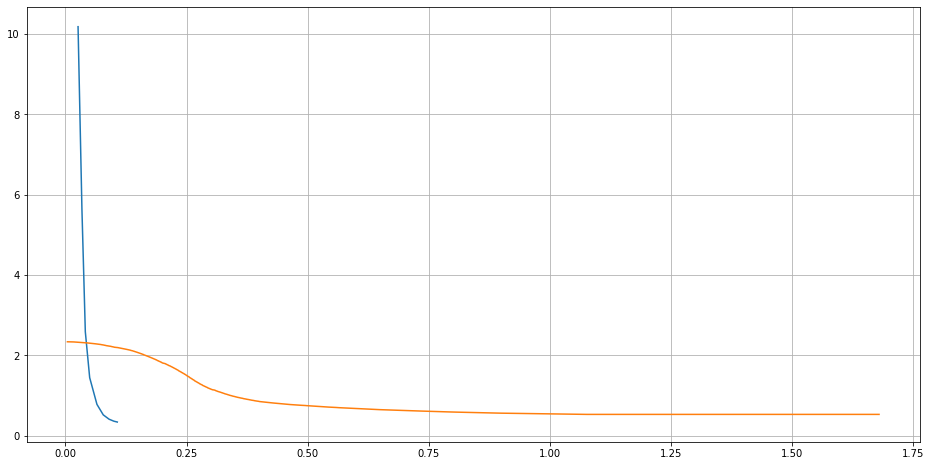

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(data_time, data)
plt.plot(data_time_1, data_1)
plt.grid()

$k = 10$, $n_2 = 100$

In [ ]:
A = np.random.sample((10, 100))
b = np.random.sample((1, 10))
x_0 = np.random.sample((1, 100))
x = x_0.copy()
k = 10
mu = 10.0
L = 1e4
sigma = 1.0
r = 1.0

In [ ]:
t = np.max(A @ x.T - b) + 1
data_1, data_time_1 = Fast_Gradient_Descent(x, k, A, b)
data, data_time = Barrier_Method(r, A, b, sigma, t, k ,100, x , x_0)

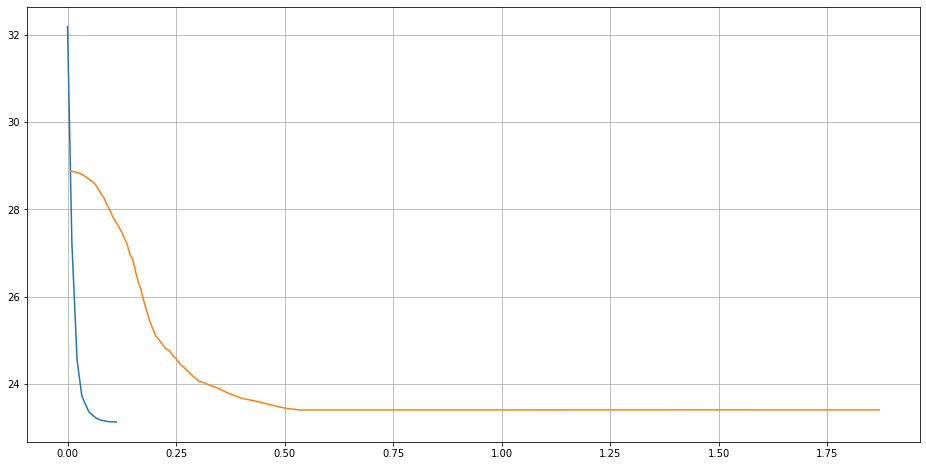

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(np.array(data_time) - 0.06, data)
plt.plot(data_time_1, data_1)
plt.grid()

$k = 10$, $n_3 = 1000$

In [ ]:
A = np.random.sample((10, 1000))
b = np.random.sample((1, 10))
x_0 = np.random.sample((1, 1000))
x = x_0.copy()
k = 10
mu = 10.0
L = 1e4
sigma = 1.0
r = 1.0

In [ ]:
t = np.max(A @ x.T - b) + 1
data_1, data_time_1 = Fast_Gradient_Descent(x, k, A, b)
data, data_time = Barrier_Method(r, A, b, sigma, t, k ,1000, x , x_0)

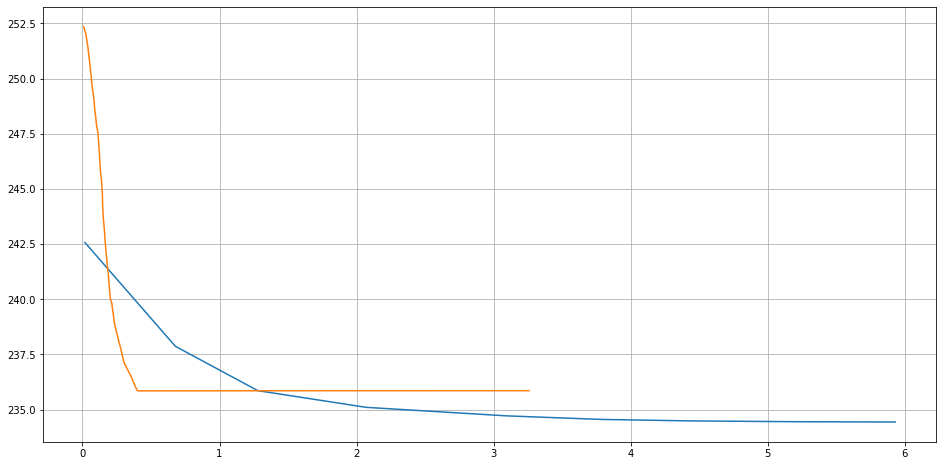

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(np.array(data_time) - 2, data)
plt.plot(data_time_1, data_1)
plt.grid()

$k = 10$, $n_4 = 10000$

In [ ]:
A = np.random.sample((10, 10000))
b = np.random.sample((1, 10))
x_0 = np.random.sample((1, 10000))
x = x_0.copy()
k = 10
mu = 10.0
L = 1e4
sigma = 1.0
r = 1.0

In [ ]:
t = np.max(A @ x.T - b) + 1
data, data_time = Barrier_Method(r, A, b, sigma, t, k ,10000, x , x_0)

In [ ]:
t = np.max(A @ x.T - b) + 1
data_1, data_time_1 = Fast_Gradient_Descent(x, k, A, b)

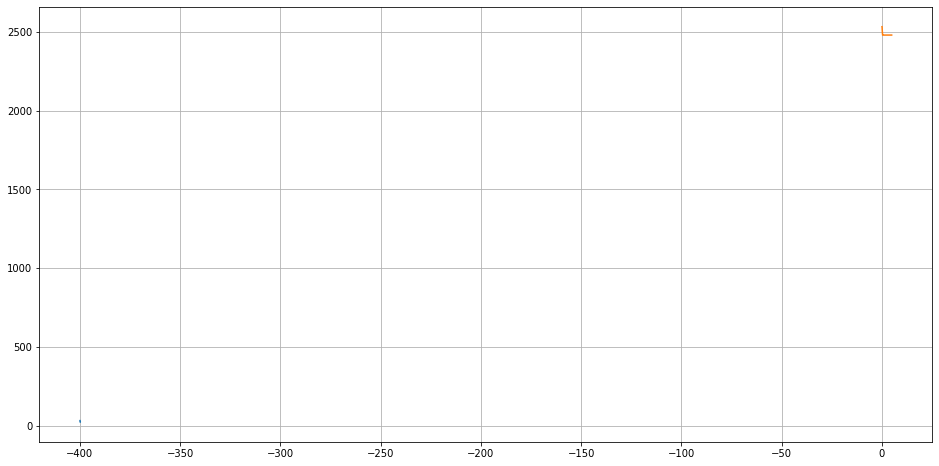

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(np.array(data_time) - 400, data)
plt.plot(data_time_1, data_1)
plt.grid()

# Test 2

$k_2 = 100$, $n = 10$

In [ ]:
A = np.random.sample((100, 10))
b = np.random.sample((1, 100))
x_0 = np.random.sample((1, 10))
x = x_0.copy()
k = 100
mu = 10.0
L = 1e4
sigma = 1.0
r = 1.0

In [ ]:
t = np.max(A @ x.T - b) + 1
data_1, data_time_1 = Fast_Gradient_Descent(x, k, A, b)
data, data_time = Barrier_Method(r, A, b, sigma, t, k ,10, x , x_0)

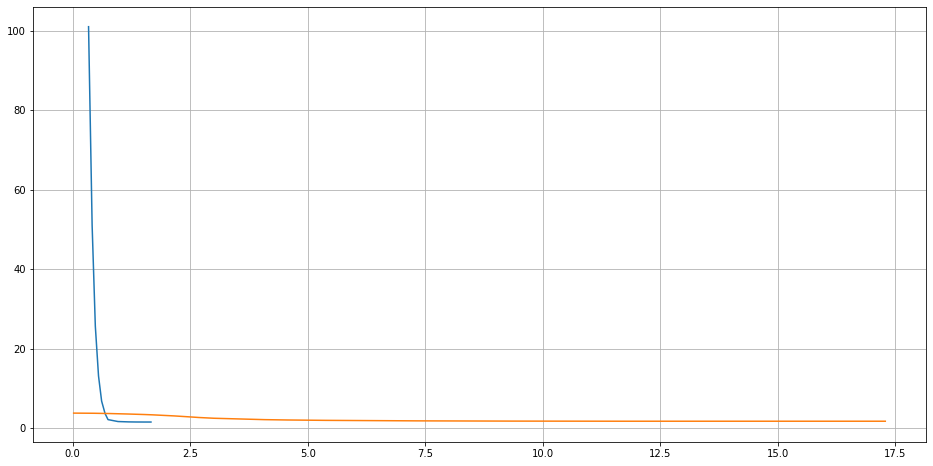

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(data_time, data)
plt.plot(data_time_1, data_1)
plt.grid()

$k_3 = 1000$, $n = 10$

In [ ]:
A = np.random.sample((1000, 10))
b = np.random.sample((1, 1000))
x_0 = np.random.sample((1, 10))
x = x_0.copy()
k = 1000
mu = 10.0
L = 1e4
sigma = 1.0
r = 1.0

In [ ]:
t = np.max(A @ x.T - b) + 1
data_1, data_time_1 = Fast_Gradient_Descent(x, k, A, b)
data, data_time = Barrier_Method(r, A, b, sigma, t, k ,10, x , x_0)

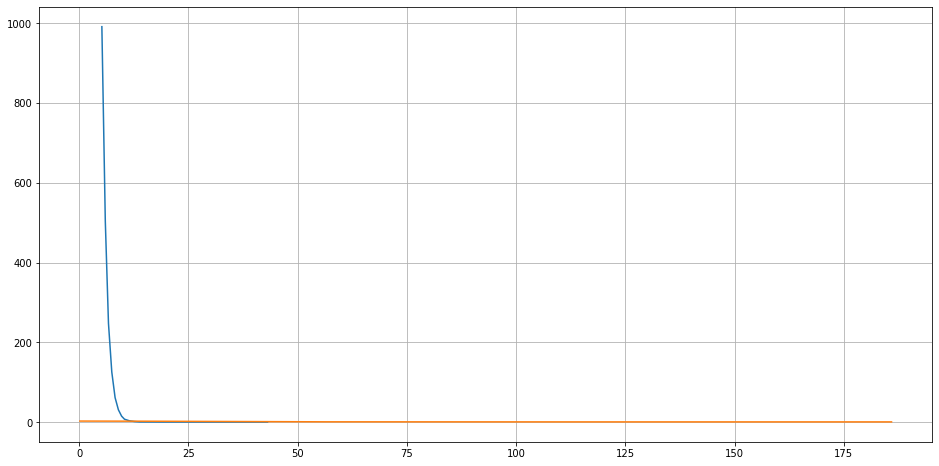

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(data_time, data)
plt.plot(data_time_1, data_1)
plt.grid()

$k_4 = 10000$, $n = 10$

In [ ]:
A = np.random.sample((10, 10))
b = np.random.sample((1, 10))
x_0 = np.random.sample((1, 10))
x = x_0.copy()
k = 10000
mu = 10.0
L = 1e4
sigma = 1.0
r = 1.0

In [ ]:
t = np.max(A @ x.T - b) + 1
data_1, data_time_1 = Fast_Gradient_Descent(x, k, A, b)
data, data_time = Barrier_Method(r, A, b, sigma, t, k ,10, x , x_0)

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(data_time, data)
plt.plot(data_time_1, data_1)
plt.grid()

# Test 3

$k = 7$, $n = 3$ 

In [ ]:
A = np.random.sample((7, 3))
b = np.random.sample((1, 7))
x_0 = np.random.sample((1, 3))
x = x_0.copy()
k = 7
mu = 10.0
L = 1e4
sigma = 1.0
r = 1.0

In [ ]:
t = np.max(A @ x.T - b) + 1
data_1, data_time_1 = Fast_Gradient_Descent(x, k, A, b)
data, data_time = Barrier_Method(r, A, b, sigma, t, k ,3, x , x_0)

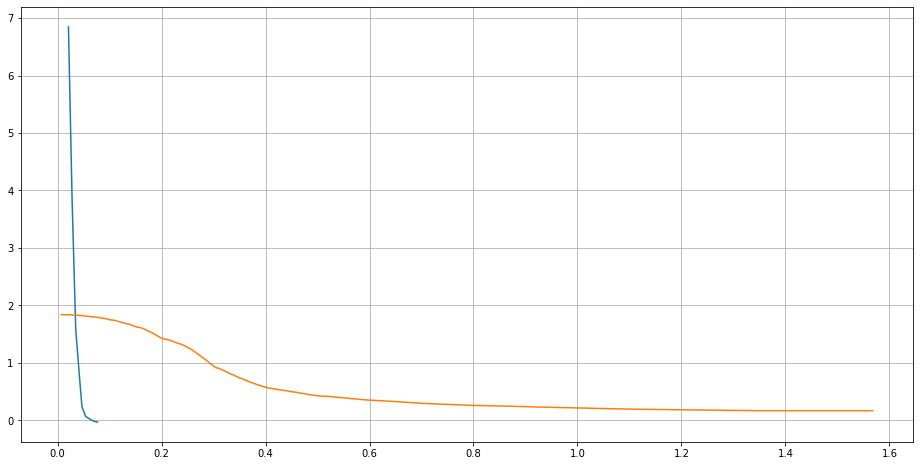

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(data_time, data)
plt.plot(data_time_1, data_1)
plt.grid()

$k = 39$, $n = 72$ 

In [ ]:
A = np.random.sample((39, 72))
b = np.random.sample((1, 39))
x_0 = np.random.sample((1, 72))
x = x_0.copy()
k = 39
mu = 10.0
L = 1e4
sigma = 1.0
r = 1.0

In [ ]:
t = np.max(A @ x.T - b) + 1
data_1, data_time_1 = Fast_Gradient_Descent(x, k, A, b)
data, data_time = Barrier_Method(r, A, b, sigma, t, k ,72, x , x_0)

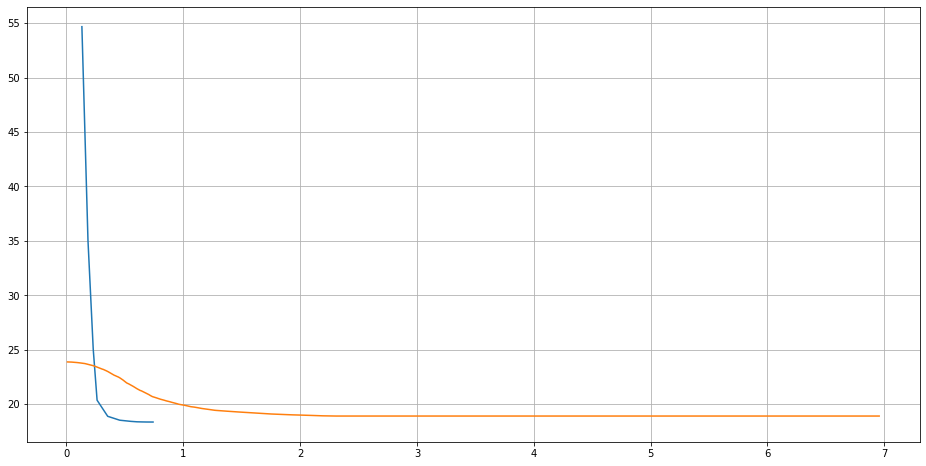

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(data_time, data)
plt.plot(data_time_1, data_1)
plt.grid()

$k = 851$, $n = 476$ 

In [ ]:
A = np.random.sample((851, 476))
b = np.random.sample((1, 851))
x_0 = np.random.sample((1, 476))
x = x_0.copy()
k = 851
mu = 10.0
L = 1e4
sigma = 1.0
r = 1.0

In [ ]:
t = np.max(A @ x.T - b) + 1
data_1, data_time_1 = Fast_Gradient_Descent(x, k, A, b)
data, data_time = Barrier_Method(r, A, b, sigma, t, k ,476, x , x_0)

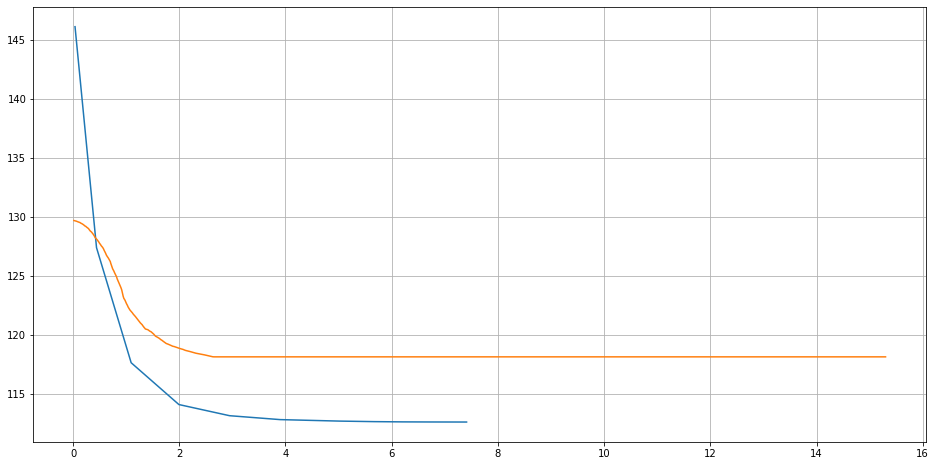

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(np.array(data_time) - 1.3, data)
plt.plot(data_time_1, data_1)
plt.grid()

$k = 2548$, $n = 7931$ 

# Conclusion

При больших n и k барьерный метод + метод Ньютона начинают работать очень долго, так как требуют много времени для вычисления градиента и гессиана на каждом шаге, при этом скорость работы метода сглаживания падает гораздо медленнее.

Преимущество барьерного метода заключается в том, что им можно вычислить ответ с любой заданной точностью. В то же время метод сглаживания не будет работать при уменьшении mu (отвечающей за точность) в ~ 10 раз, так как в месте взятия экспоненты будет переполнение. Таким образом точность вычисления очень невысока.

На тех парах n и k, где получились результаты у обоих алгоритмов, видим очень близкие значения минимума функции и оптимальной точки. Это показывает, что оба алгоритма корректны, и правильно реализованы.